In [1]:
import os
from pathlib import Path
import random
import re

In [2]:
import h5py
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import evaluate
from river import metrics
from river import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
data_path = Path('datacompletos_sin_escalar.mat')

with h5py.File(data_path, 'r') as data_file:
    print(list(data_file.keys()))
    data_all = data_file['datacompleto']
    data = pd.DataFrame(data_all).transpose()

['datacompleto']


In [4]:
# Our dataset doesn't have metadata for what class each experiment belongs to,
# so work it out from the order they're provided in.
CLASSES = [0, 1, 2, 3, 4]
def class_mapper(n):
    if n < 2460:
        return CLASSES[0] # healthy
    elif 2460 <= n < 2460 + 820:
        return CLASSES[1]
    elif 2460 <= n < 2460 + 820*2:
        return CLASSES[2]
    elif 2460 <= n < 2460 + 820*3:
        return CLASSES[3]
    elif 2460 <= n < 2460 + 820*4:
        return CLASSES[4]

data.insert(0, 'class', [class_mapper(i) for i in range(data.shape[0])])

In [50]:
# Shuffle the data so we don't pass it neatly ordered by class
#data = data.sample(frac=1, random_state=0, ignore_index=True)
data[data.columns.drop("class")]

,0,1,2,3,4,5,6,7,8,9,...,57998,57999,58000,58001,58002,58003,58004,58005,58006,58007
0,0.000189,0.000182,0.000160,0.000199,0.000233,0.000117,0.000224,0.000250,0.000170,0.000139,...,-0.000019,-0.000055,-0.000067,-0.000045,-0.000065,-0.000049,-0.000063,-0.000066,-0.000038,-0.000029
1,0.000189,0.000190,0.000142,0.000232,0.000213,0.000184,0.000212,0.000241,0.000180,0.000200,...,-0.000071,-0.000072,-0.000071,-0.000119,-0.000068,-0.000110,-0.000010,-0.000096,-0.000037,-0.000068
2,0.000223,0.000162,0.000226,0.000203,0.000194,0.000190,0.000174,0.000229,0.000231,0.000177,...,-0.000034,-0.000090,-0.000054,-0.000024,-0.000060,-0.000076,-0.000072,-0.000025,-0.000039,-0.000076
3,0.000170,0.000193,0.000219,0.000219,0.000190,0.000166,0.000160,0.000179,0.000219,0.000190,...,-0.000086,-0.000047,-0.000054,0.000017,-0.000050,-0.000076,-0.000051,0.000009,-0.000051,-0.000074
4,0.000206,0.000214,0.000144,0.000202,0.000209,0.000159,0.000192,0.000246,0.000232,0.000216,...,-0.000076,-0.000073,-0.000085,-0.000054,-0.000057,-0.000027,-0.000073,-0.000007,-0.000058,-0.000076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,-0.000027,0.000227,0.000204,0.000353,0.000354,0.000111,0.000486,0.000050,0.000451,0.000011,...,-0.000094,0.000019,-0.000166,-0.000056,-0.000127,-0.000115,-0.000007,-0.000171,-0.000049,-0.000107
5736,0.000504,0.000075,0.000041,0.000130,-0.000018,0.000467,0.000224,0.000639,0.000275,0.000453,...,-0.000127,-0.000044,-0.000092,-0.000004,-0.000227,-0.000061,-0.000167,-0.000120,-0.000157,-0.000127
5737,0.000384,-0.000014,0.000430,0.000190,0.000327,0.000044,-0.000129,-0.000058,0.000045,0.000306,...,-0.000047,-0.000061,-0.000026,-0.000018,-0.000104,0.000025,-0.000098,-0.000066,-0.000160,-0.000182
5738,-0.000146,0.000193,0.000111,-0.000024,0.000506,0.000573,0.000751,0.000365,0.000185,0.000149,...,-0.000060,-0.000163,-0.000036,-0.000091,-0.000116,-0.000055,-0.000071,0.000016,-0.000105,-0.000044


In [14]:
from joblib import Memory
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier

memory = Memory('/tmp/tmp.4n9dKHe9ME', verbose=3)

In [20]:
def noop(X, n=0):
    print(f"Noop executed with n={n}.")
    return X


@memory.cache
def noop_cachable(X, n=0):
    print(f"CACHABLE Noop actually executed with n={n}.")
    return X


noop_transformers = [FunctionTransformer(noop, kw_args={"n":n}) for n in range(7)]
noop_cachable_transformer = FunctionTransformer(noop_cachable)

In [25]:
pipeline_A = Pipeline(
    [
        ('noop1', noop_transformers[1]),
        ('column_scaling', StandardScaler()),
        ('noop2', noop_transformers[2]),
        ('dim_reduction', PCA(n_components=4)),
        ('noop3', noop_transformers[3])
    ],
    memory=memory,
    verbose=True
)

pipeline_B = Pipeline(
    [
        ('noop4', noop_transformers[1]),
        ('column_scaling', StandardScaler()),
        ('noop5', noop_transformers[2]),
        ('dim_reduction', PCA(n_components=4)),
        ('noop6', noop_transformers[3])
    ],
    memory=memory,
    verbose=True
    )

In [ ]:
pipeline_A.fit(data[data.columns.drop("class")])

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(FunctionTransformer(func=<function noop at 0x7f92d85480e0>, kw_args={'n': 1}),          0         1         2         3         4         5         6      \
0     0.000189  0.000182  0.000160  0.000199  0.000233  0.000117  0.000224   
1     0.000189  0.000190  0.000142  0.000232  0.000213  0.000184  0.000212   
2     0.000223  0.000162  0.000226  0.000203  0.000194  0.000190  0.000174   
3     0.000170  0.000193  0.000219  0.000219  0.000190  0.000166  0.000160   
4     0.000206  0.000214  0.000144  0.000202  0.000209  0.000159  0.000192   
...        ...       ...       ...       ...       ...       ...       ...   
5735 -0.000027  0.000227  0.000204  0.000353  0.000354  0.000111  0.000486   
5736  0.000504  0.000075  0.000041  0.000130 -0.000018  0.000467  0.000224  ..., 
None, None, message_clsname='Pipeline', message='(step 1 of

In [51]:
# Column-scaling
# "...each column vector in matrix X is normalized by subtracting the mean of all the elements in the column and by dividing by
# the standard deviation of the same set of data. Thus, each column of the new scaled matrix, X̆, has a
# mean of zero and a standard deviation of one."

# scaled value = (value - column_mean) / column_stdev
scaler = StandardScaler()
# We don't want to scale the class label, so skip that column
data[data.columns.drop("class")] = scaler.fit_transform(data[data.columns.drop("class")])

In [56]:
# PCA fitting
pca = PCA(n_components=8) # TODO: more components, comparing results for different numbers of components
pca.fit(data[data.columns.drop("class")]) # excludes class label column
print(sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

0.3800851859247441
[0.07500022 0.07477147 0.06190185 0.03988629 0.03985246 0.0322699
 0.03214643 0.02425656]
[4997.25101791 4989.62435962 4539.95655015 3644.27984124 3642.73409539
 3277.92273838 3271.64565805 2841.93756176]


In [57]:
samples_pca = pca.transform(data[data.columns.drop("class")])

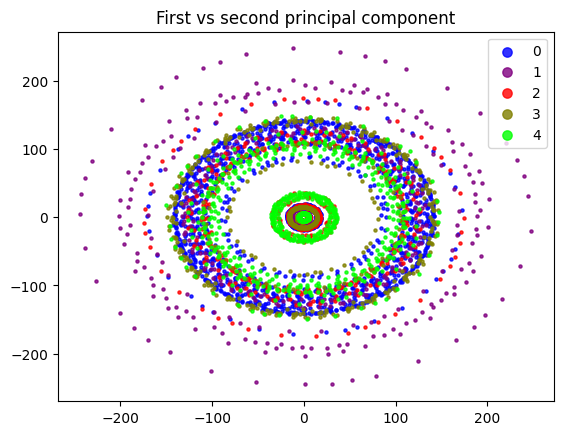

In [58]:
#color_mapping = zip(['green', 'red', 'orange', 'yellow', 'brown'], [0, 1, 2, 3, 4])
color_mapping = zip(['blue', 'purple', 'red', 'olive', 'lime'], [0, 1, 2, 3, 4])
plt.figure()
for color, dataset in color_mapping:
    plt.scatter(
        samples_pca[data['class'] == dataset, 0], samples_pca[data['class'] == dataset, 1], s=5, color=color, alpha=0.8, label=dataset
    )
plt.legend(loc="best", shadow=False, scatterpoints=1, markerscale=3)
plt.title("First vs second principal component")
plt.show()

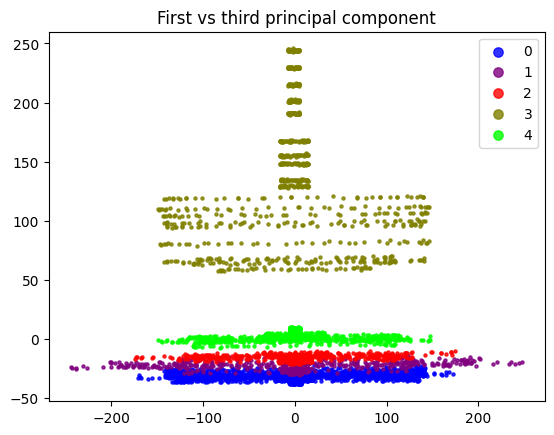

In [62]:
color_mapping = zip(['blue', 'purple', 'red', 'olive', 'lime'], [0, 1, 2, 3, 4])
plt.figure()
for color, dataset in color_mapping:
    plt.scatter(
        samples_pca[data['class'] == dataset, 0], samples_pca[data['class'] == dataset, 2], s=5, color=color, alpha=0.8, label=dataset
    )
plt.legend(loc="best", shadow=False, scatterpoints=1, markerscale=3)
plt.title("First vs third principal component")
plt.show()

In [110]:
####################
##### SIMPLE CROSS-VALIDATION #####
####################
holdout = 0.2
training = 1 - holdout

random.seed(0)
training_indices = random.sample(range(data.shape[0]), k=int(data.shape[0]*training))
training_indices.sort()
holdout_indices = list(set(range(data.shape[0])) - set(training_indices))

print(len(training_indices))
print(len(holdout_indices))
print(len(training_indices)+len(holdout_inices))

4592
1148
5740


In [94]:
# k-Nearest Neighbor (k-NN)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(samples_pca[training_indices], data["class"][training_indices])

KNeighborsClassifier(n_neighbors=10)

In [ ]:
predicted = knn.predict(samples_pca[holdout_indices])
true = data["class"][holdout_indices]

In [112]:
# confusion_map["A"]["B"]: how many times an actual class A sample was predicted as being class B
CLASSES = [0, 1, 2, 3, 4]
confusion_map = {cls0: {cls1: 0 for cls1 in CLASSES} for cls0 in CLASSES} # initialize map to 0
for index, prediction in enumerate(predicted):
    # gotta convert index back to original index... clunky
    # TODO: using dataframes properly should make this easier
    original_index = holdout_indices[index]
    actual = data["class"][original_index]
    confusion_map[actual][prediction] += 1

In [113]:
confusion_map

{0: {0: 503, 1: 0, 2: 0, 3: 0, 4: 0},
 1: {0: 21, 1: 129, 2: 0, 3: 0, 4: 1},
 2: {0: 93, 1: 0, 2: 68, 3: 0, 4: 2},
 3: {0: 0, 1: 0, 2: 0, 3: 161, 4: 4},
 4: {0: 60, 1: 0, 2: 30, 3: 0, 4: 76}}

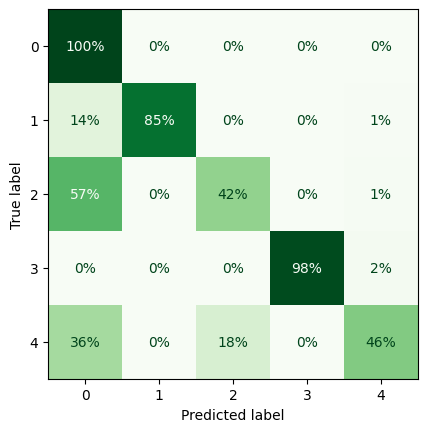

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(true, predicted)
conf_matrix_norm = confusion_matrix(true, predicted, normalize='true')
# TODO: different color scheme for diagonal vs error values.
# Trail to follow: https://stackoverflow.com/questions/64800003/seaborn-confusion-matrix-heatmap-2-color-schemes-correct-diagonal-vs-wrong-re
# Will probably need to build my own custom graph to overlay two differen heat maps
# Could maybe contribute code upstream to address this
#display = ConfusionMatrixDisplay.from_predictions(true, predicted, normalize='true', display_labels=CLASSES, values_format='.0%', colorbar=False, cmap='YlGn')
display = ConfusionMatrixDisplay.from_predictions(true, predicted, normalize='true', display_labels=CLASSES, values_format='.0%', colorbar=False, cmap='Greens')

In [183]:
def accuracy(tn, fp, fn, tp):
    return (tp+tn)/(tp+fp+fn+tn)

def precision(tn, fp, fn, tp):
    return tp/(tp+fp)

def sensibility(tn, fp, fn, tp):
    # aka recall
    return tp/(tp+fn)

def f1_score(ppv, tpr):
    return 2*(ppv*tpr)/(ppv+tpr)

def specificity(tn, fp, fn, tp):
    return tn/(tn+fp)

In [184]:
# TODO: make this a function
metrics = {"acc":0, "ppv":0, "tpr":0, "f1":0, "tnr":0}
for cls in CLASSES:
    total = sum(sum(conf_matrix))
    predicted_positives = sum(conf_matrix[:, cls])
    predicted_negatives = total - predicted_positives
    tp = conf_matrix[cls][cls]
    fp = predicted_positives - tp
    fn = sum(conf_matrix[cls]) - tp
    tn = predicted_negatives - fn
    metrics["acc"] += accuracy(tn, fp, fn, tp)
    metrics["ppv"] += precision(tn, fp, fn, tp)
    metrics["tpr"] += sensibility(tn, fp, fn, tp)
    metrics["tnr"] += specificity(tn, fp, fn, tp)

for metric in metrics:
    metrics[metric] = metrics[metric]/len(CLASSES)

metrics["f1"] = f1_score(metrics["ppv"], metrics["tpr"])

In [185]:
metrics

{'acc': 0.9264808362369339,
 'ppv': 0.8705047906938399,
 'tpr': 0.7410142901861598,
 'f1': 0.8005570610152534,
 'tnr': 0.9385294791550711}

In [161]:
conf_matrix

array([[503,   0,   0,   0,   0],
       [ 21, 129,   0,   0,   1],
       [ 93,   0,  68,   0,   2],
       [  0,   0,   0, 161,   4],
       [ 60,   0,  30,   0,  76]])

In [187]:
# Support Vector Machine (SVM)
from sklearn.svm import SVC

rho = 90 # TODO: try different value for these

# equation (9) in the paper
svc = SVC(C=1.0, kernel='poly', degree=2, coef0=0, gamma=1/(rho^2))
svc.fit(samples_pca[training_indices], data["class"][training_indices])
predicted = svc.predict(samples_pca[holdout_indices])

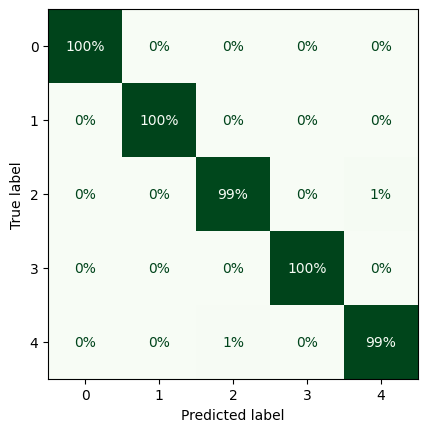

In [188]:
conf_matrix = confusion_matrix(true, predicted)
conf_matrix_norm = confusion_matrix(true, predicted, normalize='true')
# TODO: different color scheme for diagonal vs error values.
# Trail to follow: https://stackoverflow.com/questions/64800003/seaborn-confusion-matrix-heatmap-2-color-schemes-correct-diagonal-vs-wrong-re
# Will probably need to build my own custom graph to overlay two differen heat maps
# Could maybe contribute code upstream to address this
#display = ConfusionMatrixDisplay.from_predictions(true, predicted, normalize='true', display_labels=CLASSES, values_format='.0%', colorbar=False, cmap='YlGn')
display = ConfusionMatrixDisplay.from_predictions(true, predicted, normalize='true', display_labels=CLASSES, values_format='.0%', colorbar=False, cmap='Greens')

In [193]:
svc.__name__

AttributeError: 'SVC' object has no attribute '__name__'

In [190]:
metrics

{'acc': 0.9989547038327526,
 'ppv': 0.9963702225179271,
 'tpr': 0.9963411929928302,
 'f1': 0.9963557075439297,
 'tnr': 0.9993896223391607}

In [63]:
%%script true

for i in range(4):
    print(f"Samples belonging to class {i}: {len(data.loc[data['class'] == i])}")
####################
##### BASELINE #####
####################

# Balance the dataset by ensuring there's about the same amount of experiments for every class i.e. drop a bunch of "healthy" ones

# Choose 820 out of 2460, make a list with those integers
# add numbers 2460-5739 to that array
random.seed(0)
baseline = random.choices(range(2460), k=820)
baseline.extend(range(2460, 5740))

# hmmm results look too good even with this

In [64]:
%%script true

# Hoeffding tree classifier
model = tree.HoeffdingTreeClassifier(grace_period=10)
metric = metrics.ROCAUC()
# Shoving the PCA results into a DataFrame here 
evaluate.progressive_val_score(
    #zip(pd.DataFrame(samples_pca).to_dict(orient='records'), data['class'] == 0),
    zip(pd.DataFrame(samples_pca[baseline]).to_dict(orient='records'), data.iloc[baseline]['class'] == 0),
    model,
    metric,
    show_time=True,
    print_every=100,
    show_memory=True)

In [65]:
%%script true

# Adaptive Hoeffding tree classifier
model = tree.HoeffdingAdaptiveTreeClassifier(grace_period=10, seed=1)
metric = metrics.ROCAUC()
# Shoving the PCA results into a DataFrame here 
evaluate.progressive_val_score(
    zip(pd.DataFrame(samples_pca[baseline]).to_dict(orient='records'), data.iloc[baseline]['class'] == 0),
    model,
    metric,
    show_time=True,
    show_memory=True)

In [66]:
%%script true

# Extremely Fast Decision Tree classifier
# Adaptive Hoeffding tree classifier
model = tree.ExtremelyFastDecisionTreeClassifier(grace_period=10)
metric = metrics.ROCAUC()
# Shoving the PCA results into a DataFrame here 
evaluate.progressive_val_score(
    zip(pd.DataFrame(samples_pca[baseline]).to_dict(orient='records'), data.iloc[baseline]['class'] == 0),
    model,
    metric,
    show_time=True,
    show_memory=True)

In [20]:
####################
###### HYBRID ######
####################